In [41]:
import json
import random
import sys
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

# Add project source to path
project_root = Path.cwd().parent
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
from normalizer import DataNormalizer
from utils import load_config

plt.style.use('science.mplstyle')

In [42]:
# 2. LOAD ARTIFACTS
CONFIG_FILE = project_root / "data/trained_model/run_config.json"
DATA_ROOT = project_root / "data"
config = load_config(CONFIG_FILE)
model_folder = DATA_ROOT / config["output_paths_config"]["fixed_model_foldername"]
normalized_data_folder = DATA_ROOT / config["data_paths_config"]["normalized_profiles_foldername"]
raw_data_folder = DATA_ROOT / config["data_paths_config"]["raw_profiles_foldername"]

# --- Load Model, Metadata, and Test Set list ---
device = torch.device("cpu")
print(f"Forcing all operations to use device: {device}")

model = torch.jit.load(model_folder / "best_model_jit.pt", map_location=device)
model.eval()
with (normalized_data_folder / "normalization_metadata.json").open("r") as f:
    norm_metadata = json.load(f)
with (model_folder / "test_set_info.json").open("r") as f:
    test_filenames = json.load(f)["test_filenames"]

# --- Get variable lists from config ---
species_vars = sorted(config["species_variables"])
global_vars = sorted(config["global_variables"])
species_labels = [s.replace('_evolution', '') for s in species_vars]

print(f"Setup complete. Model loaded on {device}.")
print(species_vars)

Forcing all operations to use device: cpu
Setup complete. Model loaded on cpu.
['C2H2_evolution', 'CH4_evolution', 'CO2_evolution', 'CO_evolution', 'H2O_evolution', 'H2_evolution', 'HCN_evolution', 'H_evolution', 'N2_evolution', 'NH3_evolution', 'OH_evolution', 'O_evolution']


In [43]:
# 3. PREDICT AND PLOT FOR A SINGLE TEST PROFILE

# --- Select a random test file and load both versions ---
test_filename = random.choice(test_filenames)
with (normalized_data_folder / test_filename).open("r") as f:
    norm_profile = json.load(f)
with (raw_data_folder / test_filename).open("r") as f:
    raw_profile = json.load(f)

# --- Prepare the constant part of the input vector ---
initial_species_norm = [norm_profile[key][0] for key in species_vars]
global_conds = [norm_profile[key] for key in global_vars]
base_input = torch.tensor(initial_species_norm + global_conds, dtype=torch.float32)

# --- Predict ONLY for subsequent time steps (t > 0) ---
predicted_subsequent_norm = []
# Iterate starting from the second time step
for norm_time_step in norm_profile["t_time"][1:]:
    time_tensor = torch.tensor([norm_time_step], dtype=torch.float32)
    input_vector = torch.cat([base_input, time_tensor]).unsqueeze(0)
    
    #######################################################
    ###            The actual prediction                ###
    #######################################################
    with torch.no_grad():
        norm_pred = model(input_vector).squeeze(0)
        print("time:", norm_time_step)
        print("Model input vector")
        print(input_vector)
        print()
        print("output")
        print(norm_pred)
        print()
        print()
        print()
        predicted_subsequent_norm.append(norm_pred)

# --- Combine known initial state with predicted subsequent states ---
# Create the full normalized evolution trajectory
initial_species_tensor = torch.tensor(initial_species_norm, dtype=torch.float32).unsqueeze(1)
if predicted_subsequent_norm:
    predicted_subsequent_tensor = torch.stack(predicted_subsequent_norm).T

    # Combine the known t=0 data with the predicted t>0 data
    full_evolution_norm = torch.cat([initial_species_tensor, predicted_subsequent_tensor], dim=1)

# --- Denormalize the complete trajectory at once ---
predicted_evolutions_denorm = []
for i, key in enumerate(species_vars):
    series_tensor = full_evolution_norm[i]
    denorm_series = DataNormalizer.denormalize(series_tensor, norm_metadata, key)
    predicted_evolutions_denorm.append(denorm_series.numpy())

raw_times = raw_profile['t_time']

time: 0.025641033425927162
Model input vector
tensor([[ 0.5516, -0.1869, -0.3431, -2.1371,  0.6467,  0.7353, -1.3553, -1.4856,
          0.2909,  0.6851,  1.2166,  1.2986, -1.3478,  0.0886,  0.0256]])

output
tensor([ 0.5434, -0.1919, -0.3463, -2.1391,  0.6423,  0.7310, -1.3536, -1.3563,
         0.2883,  0.6866,  1.2006,  1.2993])



time: 0.051282066851854324
Model input vector
tensor([[ 0.5516, -0.1869, -0.3431, -2.1371,  0.6467,  0.7353, -1.3553, -1.4856,
          0.2909,  0.6851,  1.2166,  1.2986, -1.3478,  0.0886,  0.0513]])

output
tensor([ 0.5449, -0.1917, -0.3492, -2.1419,  0.6414,  0.7362, -1.3539, -1.2765,
         0.2886,  0.6867,  1.2076,  1.2986])



time: 0.07692306488752365
Model input vector
tensor([[ 0.5516, -0.1869, -0.3431, -2.1371,  0.6467,  0.7353, -1.3553, -1.4856,
          0.2909,  0.6851,  1.2166,  1.2986, -1.3478,  0.0886,  0.0769]])

output
tensor([ 0.5491, -0.1855, -0.3488, -2.1409,  0.6444,  0.7351, -1.3521, -1.1898,
         0.2897,  0.6902,  1.1997,  1.

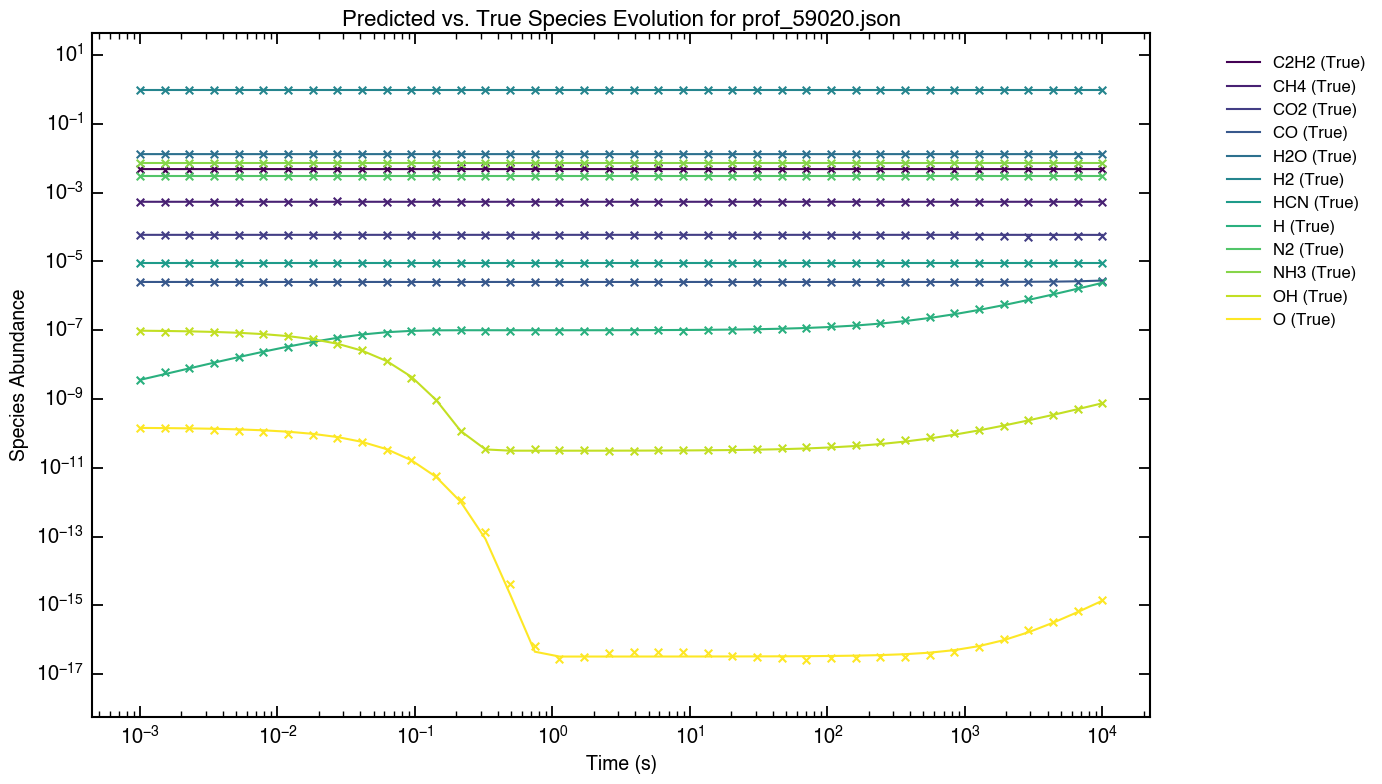

In [44]:
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(species_vars)))

for i, key in enumerate(species_vars):
    ax.plot(raw_times, raw_profile[key], color=colors[i], label=species_labels[i] + " (True)")
    ax.scatter(raw_times, predicted_evolutions_denorm[i], color=colors[i], marker='x', s=30)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Species Abundance", fontsize=14)
ax.set_title(f"Predicted vs. True Species Evolution for {test_filename}", fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#ax.set_ylim(1e-20, 2)
plt.tight_layout()
plt.show()